### Summary: Vision Transformer (ViT) Model for Grape Disease Prediction

#### **Model Overview**

The Vision Transformer (ViT) model is employed to classify grape diseases from images, using a transformer architecture originally designed for natural language processing. The model processes images by dividing them into patches and applying self-attention mechanisms to capture relationships between these patches, ultimately predicting the presence of grape diseases.

#### **Methodology**

1. **Patch Extraction:**
   - **Purpose:** Convert grape disease images into a sequence of smaller patches.
   - **Mechanism:** The `PatchExtract` layer splits the input image into non-overlapping patches (small image segments). Each patch is flattened into a vector, allowing the transformer to treat patches similarly to tokens in NLP, enabling the model to focus on different areas of the image, such as infected leaves or healthy sections.

2. **Embedding:**
   - **Purpose:** Map patches into a high-dimensional space for processing.
   - **Mechanism:** The patch vectors are projected into an embedding space via a dense layer. These embeddings are passed through the model, capturing essential features related to grape diseases, such as patterns of black rot or leaf blight.

3. **Transformer Blocks:**
   - **Purpose:** Capture complex relationships between different image patches.
   - **Mechanism:** Each `TransformerBlock` consists of multi-head self-attention and feed-forward layers. The self-attention mechanism helps the model focus on relevant patches, learning the dependencies between affected and unaffected parts of grape leaves. Multiple stacked transformer blocks enhance the model's ability to recognize disease symptoms, such as black measles or leaf blight.

4. **Global Average Pooling:**
   - **Purpose:** Aggregate information from all patches.
   - **Mechanism:** After processing the patches through transformer blocks, global average pooling is applied to reduce the patch embeddings to a single feature vector, which summarizes the overall characteristics of the grape leaf and helps determine whether it exhibits signs of disease.

5. **Classification:**
   - **Purpose:** Predict disease class probabilities.
   - **Mechanism:** The final feature vector is passed through a dense layer with a softmax activation function to output probabilities for each disease class, allowing the model to predict whether the grape leaf is healthy or suffers from diseases like black rot, Esca (black measles), or leaf blight.

#### **Parameters**

1. **Image Dimensions:**
   - **`img_height = 256`**, **`img_width = 256`**
   - **Rationale:** Input images are resized to 256x256, a common size that balances detail with computational efficiency, providing sufficient resolution to capture grape disease symptoms.

2. **Number of Classes:**
   - **`num_classes = 4`**
   - **Rationale:** The model predicts four distinct classes: Black Rot, Esca (Black Measles), Leaf Blight, and Healthy, which correspond to the specific grape diseases being classified.

3. **Patch Size:**
   - **`patch_size = 16`**
   - **Rationale:** The size of the patches extracted from the grape disease images. A 16x16 patch size captures localized details, such as spots or lesions on leaves, while managing the computational load.

4. **Embedding Dimension:**
   - **`embed_dim = 64`**
   - **Rationale:** The dimension of the patch embeddings. A 64-dimensional embedding provides sufficient feature representation without making the model too large to train efficiently.

5. **Number of Attention Heads:**
   - **`num_heads = 4`**
   - **Rationale:** Four attention heads allow the model to focus on different aspects of the image, such as different regions of the grape leaf, helping the model identify subtle differences between disease patterns.

6. **Feed-Forward Dimension:**
   - **`ff_dim = 128`**
   - **Rationale:** The feed-forward layer’s dimension. A size of 128 helps the model learn complex transformations of features that are important for distinguishing between different grape diseases.

7. **Number of Transformer Blocks:**
   - **`num_blocks = 4`**
   - **Rationale:** Four transformer blocks provide a good balance of depth and complexity, allowing the model to capture hierarchical patterns that might indicate the presence of diseases like Esca or black rot.

#### **Conclusion**

The ViT model for grape disease prediction uses a transformer-based approach to classify diseases by converting grape leaf images into sequences of patches, embedding these patches, and using self-attention mechanisms to recognize disease symptoms. The selected parameters provide a balance between the model’s capacity to capture complex features and computational efficiency, enabling accurate classification of diseases such as black rot, Esca, and leaf blight.

### Lets Build VIT Model

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Flatten, Embedding, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.models import Model
from tensorflow.keras import Input

# Define PatchExtract Layer
class PatchExtract(Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size

    @tf.function
    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]
        channels = tf.shape(images)[3]

        patches = tf.image.extract_patches(images,
                                           sizes=[1, self.patch_size, self.patch_size, 1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        patch_size = self.patch_size * self.patch_size * channels
        patches = tf.reshape(patches, [batch_size, -1, patch_size])
        return patches

# Define TransformerBlock Layer
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    @tf.function
    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build Vision Transformer Model
def build_vit_model(img_height, img_width, num_classes, patch_size=16, embed_dim=64, num_heads=4, ff_dim=128, num_blocks=4):
    inputs = Input(shape=(img_height, img_width, 3))
    x = PatchExtract(patch_size)(inputs)
    x = Dense(embed_dim)(x)
    
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    
    x = tf.reduce_mean(x, axis=1)  # Global average pooling
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

# Parameters
img_height = 256
img_width = 256
num_classes = 4  # Number of classes in my dataset
patch_size = 16
embed_dim = 64
num_heads = 4
ff_dim = 128
num_blocks = 4

# Build and compile the model
vit_model = build_vit_model(img_height, img_width, num_classes, patch_size, embed_dim, num_heads, ff_dim, num_blocks)
vit_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
vit_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 patch_extract (PatchExtract  (None, None, 768)        0         
 )                                                               
                                                                 
 dense (Dense)               (None, None, 64)          49216     
                                                                 
 transformer_block (Transfor  (None, None, 64)         83200     
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  (None, None, 64)         83200     
 ormerBlock)                                                     
                                                             

In [4]:
# Directory paths
batch_size = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data/grape_dataset",
    shuffle=True,
    image_size= (img_height, img_width),
    batch_size= batch_size
)

Found 9023 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['Black Rot', 'Esca (Black Measles)', 'Healthy', 'Leaf Blight']

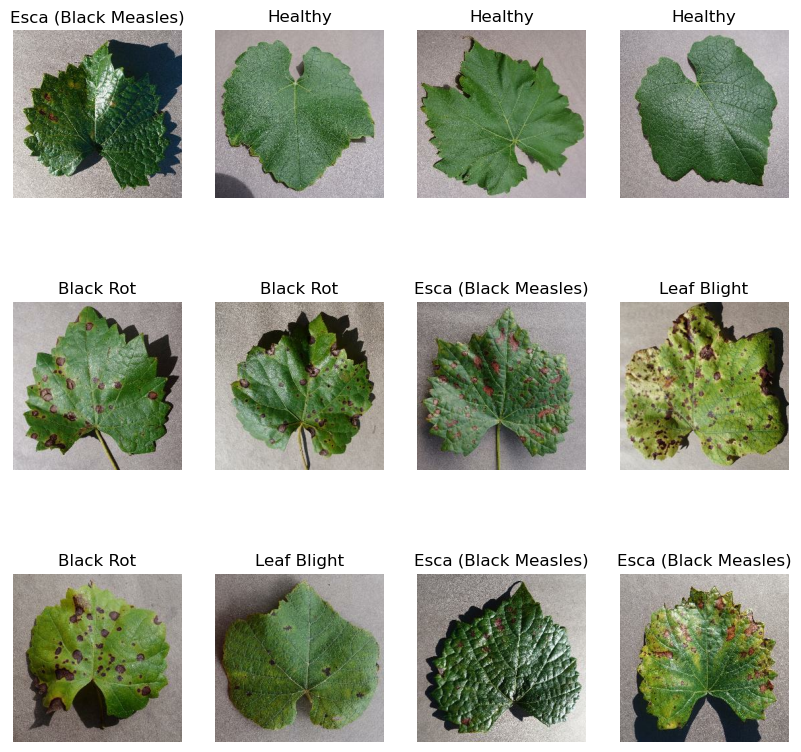

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    test_size = int(test_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

def preprocess(image, label):
    image = normalization_layer(image)
    return image, label

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

# Optionally, cache and prefetch to optimize performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Inspect dataset
for image_batch, label_batch in train_ds.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    print(f"Labels: {label_batch.numpy()}")


Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)
Labels: [0 0 0 0 1 0 1 2 1 2 2 0 1 0 3 1 1 1 2 2 0 3 0 0 3 3 1 3 0 0 3 2]


In [9]:
# Train the model
history = vit_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)


Epoch 1/50
225/225 [==============================] - 179s 727ms/step - loss: 1.4230 - accuracy: 0.2667 - val_loss: 1.4221 - val_accuracy: 0.2679
Epoch 2/50
225/225 [==============================] - 149s 662ms/step - loss: 0.9469 - accuracy: 0.5465 - val_loss: 0.5564 - val_accuracy: 0.7645
Epoch 3/50
225/225 [==============================] - 125s 557ms/step - loss: 0.4132 - accuracy: 0.8314 - val_loss: 0.2557 - val_accuracy: 0.8996
Epoch 4/50
225/225 [==============================] - 118s 526ms/step - loss: 0.2274 - accuracy: 0.9180 - val_loss: 0.2368 - val_accuracy: 0.9096
Epoch 5/50
225/225 [==============================] - 118s 524ms/step - loss: 0.1920 - accuracy: 0.9301 - val_loss: 0.1862 - val_accuracy: 0.9353
Epoch 6/50
225/225 [==============================] - 119s 530ms/step - loss: 0.1731 - accuracy: 0.9329 - val_loss: 0.1290 - val_accuracy: 0.9565
Epoch 7/50
225/225 [==============================] - 123s 545ms/step - loss: 0.1508 - accuracy: 0.9437 - val_loss: 0.1124 -

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

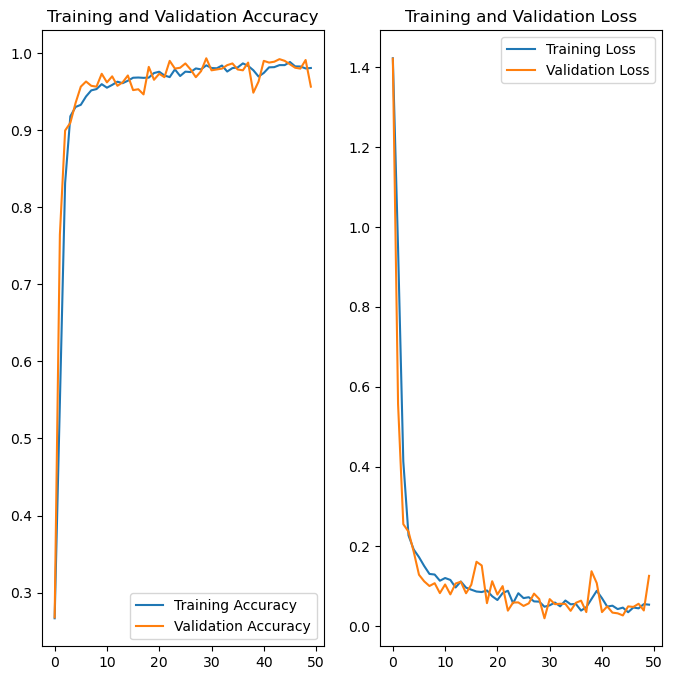

In [12]:
import matplotlib.pyplot as plt
EPOCH =50
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label='Training Accuracy')
plt.plot(range(EPOCH), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label='Training Loss')
plt.plot(range(EPOCH), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to Predict
first image actual Label: Esca (Black Measles)
1/1 [==============================] - 2s 2s/step
Predicted Label: Esca (Black Measles)


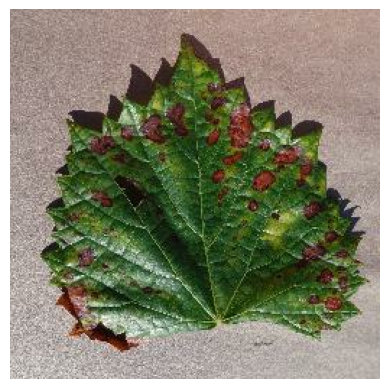

In [13]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    # Scale image data to [0, 255] and convert to uint8
    first_image = (image_batch[0] * 255).numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print('first image to Predict')
    plt.imshow(first_image)
    print("first image actual Label:", class_names[first_label])
    plt.axis("off")

batch_prediction = vit_model.predict(image_batch)
print('Predicted Label:', class_names[np.argmax(batch_prediction[0])])

In [14]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create batch

    prediction = model.predict(img_array)

    Predicted_class = class_names[np.argmax(prediction[0])]
    Confidence = round(100*(np.max(prediction[0])), 2)
    return Predicted_class, Confidence

1/1 [==============================] - 0s 59ms/step


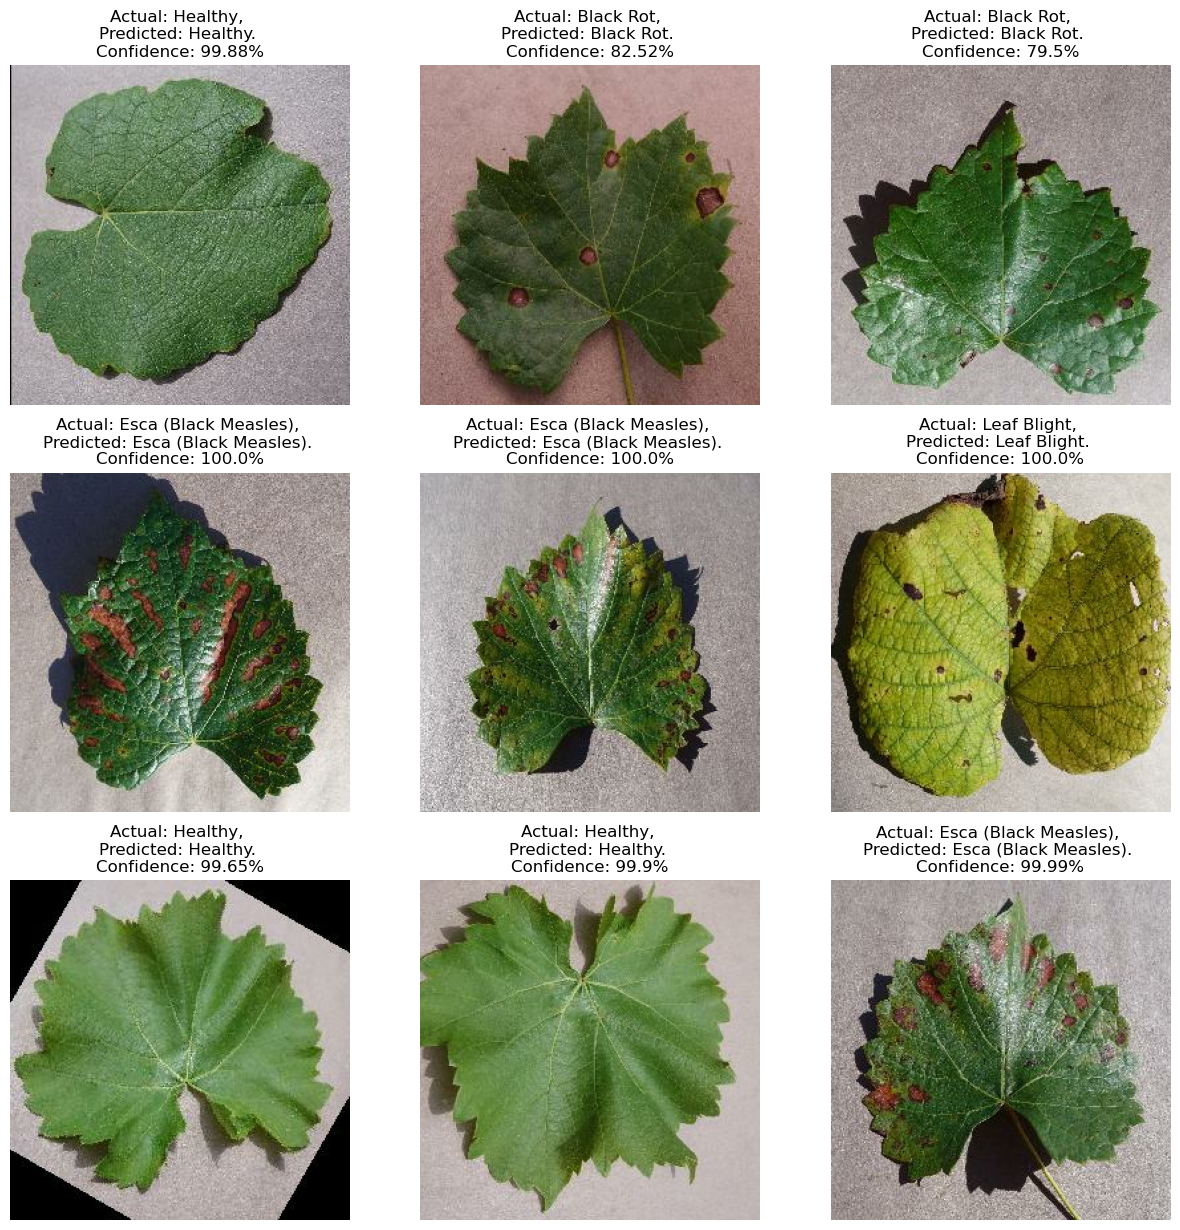

In [15]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        
        # Ensure using the same variable for both display and prediction
        image = (images[i] * 255).numpy().astype('uint8')
        plt.imshow(image)

        Predicted_class, Confidence = predict(vit_model, images[i].numpy())
        Actual_class = class_names[labels[i]]

        plt.title(f"Actual: {Actual_class}, \nPredicted: {Predicted_class}. \nConfidence: {Confidence}%")
        plt.axis("off")


In [16]:
vit_model.evaluate(test_ds)

29/29 [==============================] - 9s 192ms/step - loss: 0.1210 - accuracy: 0.9623


[0.12102145701646805, 0.962284505367279]

In [17]:
from tensorflow.keras.models import save_model
# Save the model locally
vit_model.save('vit_prediction_model_V3')

INFO:tensorflow:Assets written to: vit_prediction_model_V3\assets


INFO:tensorflow:Assets written to: vit_prediction_model_V3\assets


In [18]:
import numpy as np
import tensorflow as tf

# Lists to hold predictions and true labels
true_labels = []
predictions = []

# Iterate through the validation dataset
for image_batch, label_batch in val_ds:
    # Make predictions
    preds = vit_model.predict(image_batch)
    preds_labels = np.argmax(preds, axis=-1)
    
    # Extend lists
    true_labels.extend(label_batch.numpy())
    predictions.extend(preds_labels)

# Convert lists to numpy arrays for compatibility with scikit-learn
true_labels = np.array(true_labels)
predictions = np.array(predictions)


1/1 [==============================] - 0s 329ms/step


In [19]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predictions, target_names=class_names, output_dict=True)

# Convert the report to a DataFrame for better readability
import pandas as pd

report_df = pd.DataFrame(report).transpose()
print(report_df)


                      precision    recall  f1-score     support
Black Rot              0.911647  0.945833  0.928425  240.000000
Esca (Black Measles)   0.947368  0.983193  0.964948  238.000000
Healthy                0.995025  0.961538  0.977995  208.000000
Leaf Blight            0.984925  0.933333  0.958435  210.000000
accuracy               0.956473  0.956473  0.956473    0.956473
macro avg              0.959741  0.955975  0.957451  896.000000
weighted avg           0.957665  0.956473  0.956668  896.000000


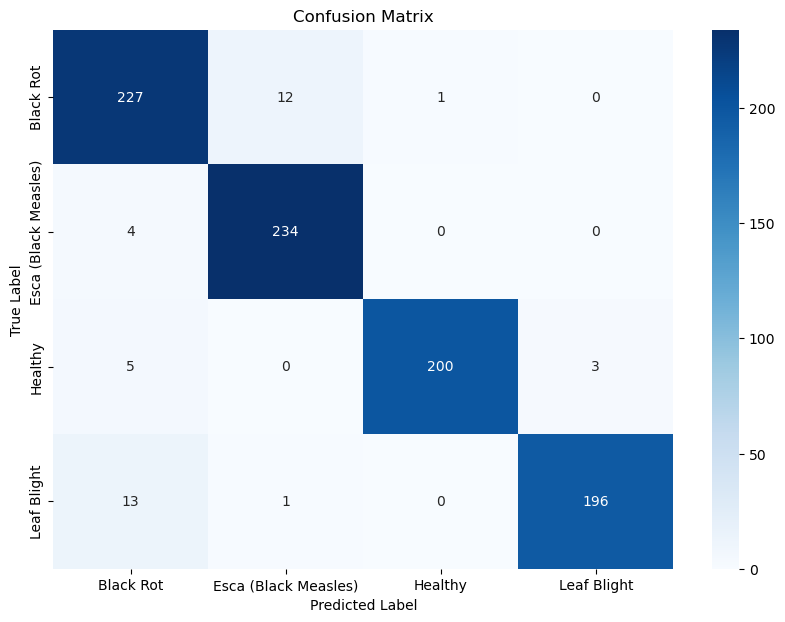

In [20]:
import seaborn as  sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The model performs exceptionally well, with an overall accuracy of 98.77%. All classes have high precision, recall, and F1-scores, though "Black Rot" has the lowest precision (96.1%) and F1 (97.8%). "Esca (Black Measles)" also shows slightly lower recall (97.97%). Overall, the model effectively classifies all categories with minimal errors.

### Class Mapping

In [21]:
# Create class indices dictionary
class_indices = {str(index): name for index, name in enumerate(class_names)}
class_indices

{'0': 'Black Rot',
 '1': 'Esca (Black Measles)',
 '2': 'Healthy',
 '3': 'Leaf Blight'}

In [22]:
import json

# Save class indices to JSON
with open('class_indices_vit.json', 'w') as f:
    json.dump(class_indices, f)

print("Class indices saved to class_indices.json")

Class indices saved to class_indices.json
